# Diffusion maps with general metric

In this notebook, we illustrate how to use an optional metric in the diffusion maps embedding.

In [217]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from pydiffmap import diffusion_map as dm

%matplotlib inline

# 2D Four-well potential 

Load sampled data: discretized Langevin dynamics at temperature T=1, friction 1, and time step size dt=0.01, with double-well potentials in x and y, with higher barrier in y.

In [218]:
X=np.load('Data/4wells_traj.npy')

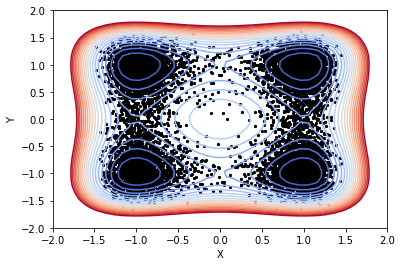

In [219]:
def DW1(x):
        return 2.0*(np.linalg.norm(x)**2-1.0)**2

def DW2(x):
        return 4.0*(np.linalg.norm(x)**2-1.0)**2

def DW(x):
    return DW1(x[0]) + DW1(x[1])

from matplotlib import cm

mx=5

xe=np.linspace(-mx, mx, 100)
ye=np.linspace(-mx, mx, 100)
energyContours=np.zeros((100, 100))
for i in range(0,len(xe)):
            for j in range(0,len(ye)):
                xtmp=np.array([xe[i], ye[j]] )
                energyContours[j,i]=DW(xtmp)

levels = np.arange(0, 10, 0.5)
plt.contour(xe, ye, energyContours, levels, cmap=cm.coolwarm)
plt.scatter(X[:,0], X[:,1], s=5, c='k')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.show()


In [220]:

def periodicMetric(v1, v2):
    
    upperLimitPBC=1
    lowerLimitPBC=-1
    
    BoxLength = upperLimitPBC - lowerLimitPBC
        
    v = v1 - v2
    
    v = v - BoxLength*np.floor(v / BoxLength)
    
        
    return np.linalg.norm(v)


 Compute diffusion map embedding

In [ ]:
mydmap = dm.DiffusionMap(n_evecs = 2, epsilon = .2, alpha = 0.5, k=200, metric=periodicMetric)

dmap = mydmap.fit_transform(X)

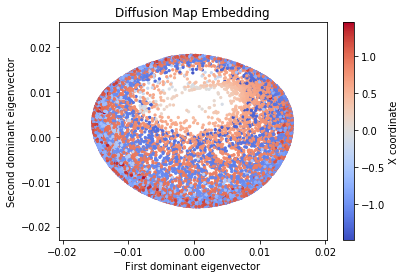

In [93]:
from matplotlib import cm
plt.scatter(dmap[:,0], dmap[:,1], c=X[:,0], s=5, cmap=cm.coolwarm)

clb=plt.colorbar()
clb.set_label('X coordinate')
plt.xlabel('First dominant eigenvector')
plt.ylabel('Second dominant eigenvector')
plt.title('Diffusion Map Embedding')

plt.show()

# Dimer trajectory

We import trajectory of two particles connected by a double-well potential, which is a function of a radius: V(r) = V_DW(r). The dimer was simulated at 300K with Langevin dynamics using OpenMM. The obvious collective variable is the radius case and we demonstrate how the first dominant eigenvector obtained from the diffusion map clearly correlates with this reaction coordinate. As a metric, we use the root mean square deviation (RMSD) from the package  https://pypi.python.org/pypi/rmsd/1.2.5.  

In [222]:
traj=np.load('Data/dimer_trajectory.npy')
energy=np.load('Data/dimer_energy.npy')
print('Loaded trajectory of '+repr(len(traj))+' steps of dimer molecule: '+repr(traj.shape[1])+' particles in dimension '+repr(traj.shape[2])+'.')

Loaded trajectory of 1000 steps of dimer molecule: 2 particles in dimension 3.


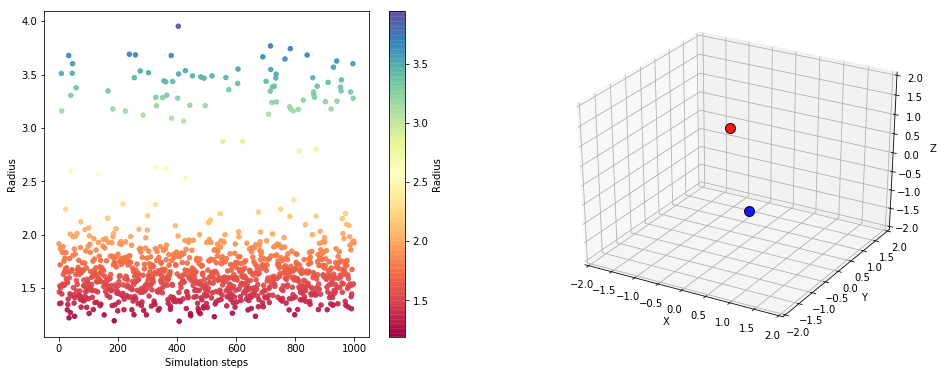

In [223]:
def compute_radius(X):
    return np.linalg.norm(X[:,0,:]-X[:,1,:], 2, axis=1)

fig = plt.figure(figsize=[16,6])
ax = fig.add_subplot(121)

radius= compute_radius(traj)
cax2 = ax.scatter(range(len(radius)), radius, c=radius, s=20,alpha=0.90,cmap=plt.cm.Spectral)
cbar = fig.colorbar(cax2)
cbar.set_label('Radius')
ax.set_xlabel('Simulation steps')
ax.set_ylabel('Radius')


ax2 = fig.add_subplot(122, projection='3d')

L=2

i=0

ax2.scatter(traj[i,0,0], traj[i,0,1], traj[i,0,2], c='b', s=100, alpha=0.90, edgecolors='none', depthshade=True,)
ax2.scatter(traj[i,1,0], traj[i,1,1], traj[i,1,2], c='r', s=100, alpha=0.90, edgecolors='none',  depthshade=True,)
    
ax2.set_xlim([-L, L])
ax2.set_ylim([-L, L])
ax2.set_zlim([-L, L])

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
   
plt.show()


In [170]:
# download from https://pypi.python.org/pypi/rmsd/1.2.5
import rmsd


def myRMSDmetricPrecentered(arr1, arr2):
    """
    This function is built under the assumption that the space dimension is 3!!!
    Requirement from sklearn radius_neighbors_graph: The callable should take two arrays as input and return one value indicating the distance between them.
     Input: One row from reshaped XYZ trajectory as number of steps times nDOF
     Inside: Reshape to XYZ format and apply rmsd as r=rmsd(X[i], X[j])
     Output: rmsd distance
    """
    
    nParticles = len(arr1) / 3;
    assert (nParticles == int(nParticles))

    X1 = arr1.reshape(int(nParticles), 3 )
    X2 = arr2.reshape(int(nParticles), 3 )

    X1 = X1 -  rmsd.centroid(X1)
    X2 = X2 -  rmsd.centroid(X2)

    return rmsd.kabsch_rmsd(X1, X2)



Compute diffusion map embedding using the rmsd metric from above.

In [ ]:
epsilon=0.1

Xresh=traj.reshape(traj.shape[0], traj.shape[1]*traj.shape[2])
mydmap = dmpy.DiffusionMap(n_evecs = 1, epsilon = epsilon, alpha = 0.5, k=1000, metric=myRMSDmetricPrecentered)
dmap = mydmap.fit_transform(Xresh)



Plot the dominant eigenvector over radius, to show the correlation with this collective variable.

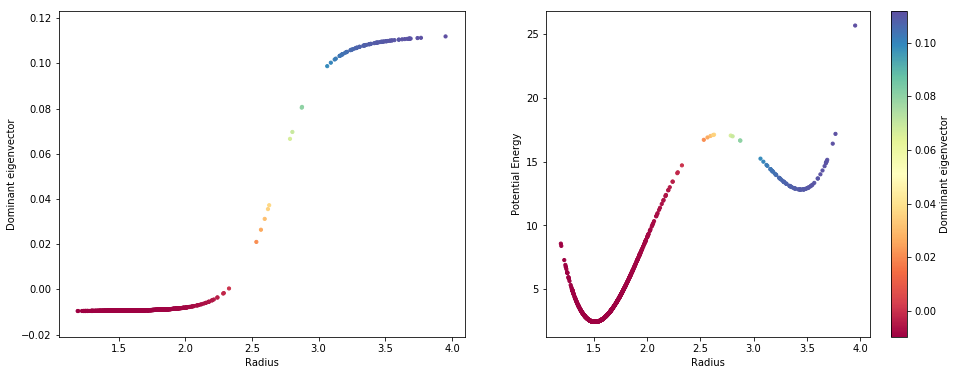

In [189]:
evecs = mydmap.evecs

fig = plt.figure(figsize=[16,6])
ax = fig.add_subplot(121)

ax.scatter(compute_radius(traj), evecs[:,0], c=evecs[:,0], s=10, cmap=plt.cm.Spectral)
ax.set_xlabel('Radius')
ax.set_ylabel('Dominant eigenvector')

ax2 = fig.add_subplot(122)
#
cax2 = ax2.scatter(compute_radius(traj), energy, c=evecs[:,0], s=10, cmap=plt.cm.Spectral)
ax2.set_xlabel('Radius')
ax2.set_ylabel('Potential Energy')
cbar = fig.colorbar(cax2)
cbar.set_label('Domninant eigenvector')
plt.show()